In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
from linearmodels import PanelOLS
from linearmodels import RandomEffects

# Registerd Business Data in SF (needs check)

In [178]:
df_raw = pd.read_csv('Registered_Business_Locations_-_San_Francisco.csv')

/var/folders/kz/dhtdp71n1q98lc7x715t7c0h0000gp/T/ipykernel_66715/3740887232.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('Registered_Business_Locations_-_San_Francisco.csv')


In [179]:
df = df_raw[df_raw['State'] == 'CA']

In [26]:
df['Business Account Number'].duplicated().sum()

86612

In [180]:
df = df.loc[:,['Source Zipcode','Location Start Date', 'City','Business End Date',
            'Location End Date','Neighborhoods - Analysis Boundaries','NAICS Code Description']]

In [181]:
#data validation: 98250 is actually in Washington State... Don't know where does it go wrong
df[df['Source Zipcode']=='98250']


,Source Zipcode,Location Start Date,City,Business End Date,Location End Date,Neighborhoods - Analysis Boundaries,NAICS Code Description
97911,98250,05/29/2019,San Francisco,NaN,NaN,Haight Ashbury,Real Estate and Rental and Leasing Services


In [79]:
df.shape

(298133, 6)

In [247]:
df

,Source Zipcode,Location Start Date,City,Business End Date,Location End Date,Neighborhoods - Analysis Boundaries,NAICS Code Description
0,94133-3713,2012-08-01,San Francisco,NaN,NaN,Chinatown,"Arts, Entertainment, and Recreation"
1,94108,2020-02-12,San Francisco,NaN,03/05/2020,Chinatown,Private Education and Health Services
2,94108,2020-01-15,San Francisco,NaN,NaN,Chinatown,Private Education and Health Services
3,94132,2015-02-05,San Francisco,NaN,09/30/2022,Lakeshore,NaN
4,94103-1235,2013-11-26,San Francisco,NaN,NaN,Mission,"Professional, Scientific, and Technical Services"
...,...,...,...,...,...,...,...
306868,94010,2019-11-30,Burlingame,NaN,NaN,NaN,Real Estate and Rental and Leasing Services
306869,94123,2023-04-09,San Francisco,NaN,NaN,Marina,Construction
306870,94118,2023-04-18,San Francisco,NaN,NaN,Inner Richmond,Food Services
306871,94102,2023-04-24,San Francisco,NaN,NaN,Hayes Valley,Private Education and Health Services


In [244]:
df['Location Start Date'] = pd.to_datetime(df['Location Start Date'])

In [81]:
df.isnull().sum()

Source Zipcode                            162
Location Start Date                         0
City                                        1
Location End Date                      118247
Neighborhoods - Analysis Boundaries     47579
NAICS Code Description                 133640
dtype: int64

# Data Cleaning: active business

In [199]:
#selecting active business
active_df = df[df['Location End Date'].isnull() & df['Business End Date'].isnull()]

active_df = active_df.drop(['Business End Date','Location End Date'],axis=1)

#change data type
active_df['Location Start Date'] = pd.to_datetime(active_df['Location Start Date'])

#cleaning zip code 
active_df['Source Zipcode'] = active_df['Source Zipcode'].str[:5]


In [131]:
active_df.isnull().sum()

Source Zipcode                            69
Location Start Date                        0
City                                       1
Neighborhoods - Analysis Boundaries    17154
NAICS Code Description                 26735
dtype: int64

In [200]:
sf_zipcode = [94002, 94010, 94014, 94015, 94025, 94044, 94061, 94062, 94063,
       94065, 94066, 94080, 94102, 94103, 94105, 94107, 94108, 94109,
       94111, 94115, 94122, 94129, 94132, 94133, 94134, 94158, 94401,
       94402, 94403, 94404, 94901, 94903, 94920, 94925, 94939, 94945,
       94947, 94949, 94960, 94965]

In [201]:

#dropping NA (69) zipcodes
active_df = active_df.dropna(subset=['Source Zipcode'])

active_df['Source Zipcode'] = active_df['Source Zipcode'].astype(int)

In [202]:
mask = active_df['Source Zipcode'].isin(sf_zipcode)
active_df_sf = active_df.loc[mask]

In [203]:
active_df_sf.loc[:, 'NAICS Code Description'] = active_df_sf['NAICS Code Description'].fillna('Other')

/var/folders/kz/dhtdp71n1q98lc7x715t7c0h0000gp/T/ipykernel_66715/1873372073.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_df_sf.loc[:, 'NAICS Code Description'] = active_df_sf['NAICS Code Description'].fillna('Other')


In [205]:
active_df_sf = active_df_sf.reset_index(drop = True)
active_df_sf

,Source Zipcode,Location Start Date,City,Neighborhoods - Analysis Boundaries,NAICS Code Description
0,94133,2012-08-01,San Francisco,Chinatown,"Arts, Entertainment, and Recreation"
1,94108,2020-01-15,San Francisco,Chinatown,Private Education and Health Services
2,94103,2013-11-26,San Francisco,Mission,"Professional, Scientific, and Technical Services"
3,94103,2006-01-01,San Francisco,Mission,Other
4,94133,1968-10-01,San Francisco,North Beach,Other
...,...,...,...,...,...
57664,94103,2018-03-15,San Francisco,South of Market,Real Estate and Rental and Leasing Services
57665,94109,2022-03-21,San Francisco,Nob Hill,Financial Services
57666,94109,2020-05-06,San Francisco,Russian Hill,"Professional, Scientific, and Technical Services"
57667,94010,2019-11-30,Burlingame,NaN,Real Estate and Rental and Leasing Services


# Group by Quarter

In [230]:
active_df_copy = active_df_sf.copy()
active_df_copy['y_dt'] = active_df_copy['Location Start Date'].dt.to_period('Q').dt.start_time

In [242]:
active_df_copy

,Source Zipcode,Location Start Date,City,Neighborhoods - Analysis Boundaries,NAICS Code Description,y_dt
0,94133,2012-08-01,San Francisco,Chinatown,"Arts, Entertainment, and Recreation",2012-07-01
1,94108,2020-01-15,San Francisco,Chinatown,Private Education and Health Services,2020-01-01
2,94103,2013-11-26,San Francisco,Mission,"Professional, Scientific, and Technical Services",2013-10-01
3,94103,2006-01-01,San Francisco,Mission,Other,2006-01-01
4,94133,1968-10-01,San Francisco,North Beach,Other,1968-10-01
...,...,...,...,...,...,...
57664,94103,2018-03-15,San Francisco,South of Market,Real Estate and Rental and Leasing Services,2018-01-01
57665,94109,2022-03-21,San Francisco,Nob Hill,Financial Services,2022-01-01
57666,94109,2020-05-06,San Francisco,Russian Hill,"Professional, Scientific, and Technical Services",2020-04-01
57667,94010,2019-11-30,Burlingame,NaN,Real Estate and Rental and Leasing Services,2019-10-01


In [243]:
#check
active_df_copy[active_df_copy['y_dt'] == '2013-10-01']

,Source Zipcode,Location Start Date,City,Neighborhoods - Analysis Boundaries,NAICS Code Description,y_dt
2,94103,2013-11-26,San Francisco,Mission,"Professional, Scientific, and Technical Services",2013-10-01
340,94105,2013-11-20,San Francisco,Financial District/South Beach,Accommodations,2013-10-01
624,94107,2013-11-04,San Francisco,Mission Bay,Food Services,2013-10-01
636,94108,2013-12-04,San Francisco,Financial District/South Beach,Multiple,2013-10-01
655,94107,2013-12-01,San Francisco,Financial District/South Beach,Multiple,2013-10-01
...,...,...,...,...,...,...
56536,94107,2013-12-02,San Francisco,Potrero Hill,"Professional, Scientific, and Technical Services",2013-10-01
56831,94122,2013-12-13,San Francisco,Inner Sunset,"Professional, Scientific, and Technical Services",2013-10-01
57316,94103,2013-10-01,San Francisco,South of Market,Retail Trade,2013-10-01
57317,94132,2013-11-01,San Francisco,Lakeshore,Retail Trade,2013-10-01


In [238]:
active_df_quarter = active_df_copy.groupby(['Source Zipcode', 'y_dt'])['Location Start Date'].count()

In [239]:
active_df_quarter.reset_index()

,Source Zipcode,y_dt,Location Start Date
0,94002,1988-10-01,1
1,94002,1994-01-01,1
2,94002,1999-04-01,1
3,94002,2001-10-01,1
4,94002,2003-07-01,1
...,...,...,...
4084,94965,2022-01-01,4
4085,94965,2022-07-01,2
4086,94965,2022-10-01,3
4087,94965,2023-01-01,1


In [240]:
active_df_quarter = active_df_quarter.reset_index()
active_df_quarter = active_df_quarter.rename(columns={'Location Start Date': 'New Business Count', 'Source Zipcode': 'Zip Code'})
active_df_quarter

,Zip Code,y_dt,New Business Count
0,94002,1988-10-01,1
1,94002,1994-01-01,1
2,94002,1999-04-01,1
3,94002,2001-10-01,1
4,94002,2003-07-01,1
...,...,...,...
4084,94965,2022-01-01,4
4085,94965,2022-07-01,2
4086,94965,2022-10-01,3
4087,94965,2023-01-01,1


In [225]:
active_df_quarter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4089 entries, 0 to 4088
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Zip Code            4089 non-null   int64         
 1   y_dt                4089 non-null   datetime64[ns]
 2   New Business Count  4089 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 96.0 KB


# Before 2011

In [226]:
#before_2011 = active_df_quarter[active_df_quarter['y_dt'].dt.year <= 2010].groupby(['Zip Code']).count()


In [185]:

#before_2011 = active_df_quarter[active_df_quarter['Location Start Date'].dt.year <= 2010].groupby(['Zip Code']).count()[['Location Start Date']]


#before_2011.index.names = ['Zipcode', 'Business Type']
#before_2011 = before_2011.rename(columns = {'Location Start Date': 'Count'})
#before_2011 = before_2011.reset_index()


In [186]:
#delete unknown zipcode
#before_2011 = before_2011[before_2011['Zipcode'] != 'nan']

# after 2011, group by zip code and quarter

In [214]:
after_2011 = active_df_quarter.loc[active_df_quarter['y_dt'].dt.year >= 2009].reset_index(drop=True)

In [216]:
#check
after_2011[after_2011['Zip Code'] == 94002]

,Zip Code,y_dt,New Business Count
0,94002,2009-01-01,1
1,94002,2009-04-01,1
2,94002,2011-01-01,1
3,94002,2011-04-01,1
4,94002,2012-01-01,1
5,94002,2012-04-01,1
6,94002,2012-07-01,1
7,94002,2013-01-01,1
8,94002,2013-07-01,1
9,94002,2014-01-01,1


In [31]:
after_2011 = active_df_copy[active_df_copy['y_dt'].dt.year >= 2009].groupby(['y_dt', 'Source Zipcode']).count()[['City']]

after_2011.index.names = ['y_dt', 'Zip Code']
after_2011 = after_2011.rename(columns={'City': 'Count'})
after_2011 = after_2011.reset_index()


In [217]:
#validation: SF financial district

after_2011[after_2011['Zip Code'] == 94111]

,Zip Code,y_dt,New Business Count
864,94111,2009-01-01,30
865,94111,2009-04-01,23
866,94111,2009-07-01,17
867,94111,2009-10-01,15
868,94111,2010-01-01,53
869,94111,2010-04-01,28
870,94111,2010-07-01,28
871,94111,2010-10-01,15
872,94111,2011-01-01,57
873,94111,2011-04-01,41


In [33]:
after_2011.to_csv('sf_newly_active_2009.csv',index=False)

# Match with e_rent and acs data (leave the below codes alone!)

In [286]:
df = pd.read_excel('/Users/yilingwu/Desktop/Data Science Clinic/Effective Rent By ZipCode - RealPage.xlsx')

/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
def read_pgim_data(df, city):
    df = (df.set_index(['Geography Name', 'Geography Type', 'Market Name', 'Unique ID',
               'Metric Type', 'Metric Name', 'Category', 'Niche']).stack().reset_index()
         .rename(columns={'level_8' : 'time_period', 0 : 'e_rent'})
        )
    pgim_all = df[df['Market Name'].str.upper().str.contains(city).fillna(False)]
    pgim_all = pgim_all[['Unique ID','time_period','e_rent']]
    pgim_all = pgim_all.rename(columns = {'Unique ID': 'Zip Code','time_period':'y_dt'}).reset_index()

    quarter_dict = {'Q1': '-01-01', 'Q2': '-04-01', 'Q3': '-07-01', 'Q4': '-10-01'}
    pgim_all['y_dt'] = pgim_all['y_dt'].apply(lambda x: x[1:5] + quarter_dict[x[5:]])
    pgim_all['y_dt'] = pd.to_datetime(pgim_all['y_dt'])

    pgim_all = pgim_all.drop(columns = 'index')

    #we only want data from 2011-2019
    mask = (pgim_all['y_dt'].dt.year >= 2011) & (pgim_all['y_dt'].dt.year <= 2019)
    df_filtered = pgim_all.loc[mask]

    df_filtered = df_filtered.reset_index(drop = True)

    return df_filtered

In [287]:
read_pgim_data(df,'SAN FRAN')

,Zip Code,y_dt,e_rent
0,94108,2011-01-01,1699.0
1,94108,2011-04-01,1714.0
2,94108,2011-07-01,1787.0
3,94108,2011-10-01,1864.0
4,94108,2012-01-01,2001.0
...,...,...,...
1514,94925,2018-10-01,3969.0
1515,94925,2019-01-01,4049.0
1516,94925,2019-04-01,4113.0
1517,94925,2019-07-01,4016.0


In [238]:
df_filtered.to_csv('sf_pgim.csv',index=False)

# Merge

In [2]:
df_filtered = pd.read_csv('sf_pgim.csv')
after_2011 = pd.read_csv('sf_newly_activeB.csv')

In [4]:
df_filtered

,Zip Code,y_dt,e_rent
0,94108,2011-01-01,1699.0
1,94108,2011-04-01,1714.0
2,94108,2011-07-01,1787.0
3,94108,2011-10-01,1864.0
4,94108,2012-01-01,2001.0
...,...,...,...
1514,94925,2018-10-01,3969.0
1515,94925,2019-01-01,4049.0
1516,94925,2019-04-01,4113.0
1517,94925,2019-07-01,4016.0


In [75]:
df_filtered['Zip Code'] = df_filtered['Zip Code'].astype(str)

In [76]:
merge_df_test = df_filtered.merge(after_2011, on=['y_dt', 'Zip Code'], how='left', indicator=True)
merge_df_test[merge_df_test['_merge'] == 'left_only']['Zip Code'].nunique()

#there are 27 zip codes that shows in PGIM dataset but not in business movement dataset

27

In [77]:
merge_df = df_filtered.merge(after_2011, on=['y_dt', 'Zip Code'], how='inner')
merge_df = merge_df.rename(columns = {'Count':'New Business Count'})

In [78]:
merge_df.head()

,Zip Code,y_dt,e_rent,New Business Count
0,94108,2011-01-01,1699.0,37
1,94108,2011-04-01,1714.0,25
2,94108,2011-07-01,1787.0,27
3,94108,2011-10-01,1864.0,21
4,94108,2012-01-01,2001.0,37


In [88]:
merge_df['y_dt'] = pd.to_datetime(merge_df['y_dt'])
merge_df['Zip Code'] = merge_df['Zip Code'].astype(int)

In [89]:
acs_all = pd.read_csv('Q_all_ACS_2010-2019.csv')
acs_all['y_dt'] = pd.to_datetime(acs_all['y_dt'])

In [264]:
sf_merge = pd.merge(acs_all,merge_df, on = ['y_dt','Zip Code'], how = 'inner')
sf_merge['Housing/person'] = sf_merge['Quarterly Total Housing'] / sf_merge['Quarterly Total Population']

In [243]:
sf_merge

,y_dt,Zip Code,Quarterly Total Population,Quarterly Total Housing,e_rent,New Business Count,Housing/person
0,2011-01-01,94002,25797,10936,1491.0,1,0.423925
1,2011-04-01,94002,25883,10935,1603.0,1,0.422478
2,2012-01-01,94002,26141,10935,1701.0,1,0.418308
3,2012-04-01,94002,26225,10942,1793.0,1,0.417235
4,2012-07-01,94002,26311,10949,1874.0,1,0.416138
...,...,...,...,...,...,...,...
1206,2018-01-01,94965,11408,6459,3121.0,7,0.566182
1207,2018-10-01,94965,11397,6387,3155.0,1,0.560411
1208,2019-01-01,94965,11394,6364,3261.0,2,0.558540
1209,2019-07-01,94965,11388,6316,3115.0,1,0.554619


In [125]:
china_town = sf_merge[sf_merge['Zip Code'] == 94108]

In [103]:
china_town.columns

Index(['Quarterly Total Population', 'Quarterly Total Housing', 'e_rent',
       'New Business Count', 'year'],
      dtype='object')

In [226]:
#sf_merge['New Business Count'] = np.log(sf_merge['New Business Count'])

# Modeling for Chinatown

In [127]:
features= ['Quarterly Total Population','Quarterly Total Housing','New Business Count']
X = china_town[features]
y = china_town['e_rent']

In [128]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 e_rent   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     50.49
Date:                Thu, 27 Apr 2023   Prob (F-statistic):           4.87e-12
Time:                        21:23:44   Log-Likelihood:                -237.23
No. Observations:                  35   AIC:                             482.5
Df Residuals:                      31   BIC:                             488.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

# Model For SF

In [322]:
sf_merge = pd.merge(acs_all,merge_df, on = ['y_dt','Zip Code'], how = 'inner')
sf_merge['Housing/person'] = sf_merge['Quarterly Total Housing'] / sf_merge['Quarterly Total Population']

In [323]:
sf_merge

,y_dt,Zip Code,Quarterly Total Population,Quarterly Total Housing,e_rent,New Business Count,Housing/person
0,2011-01-01,94002,25797,10936,1491.0,1,0.423925
1,2011-04-01,94002,25883,10935,1603.0,1,0.422478
2,2012-01-01,94002,26141,10935,1701.0,1,0.418308
3,2012-04-01,94002,26225,10942,1793.0,1,0.417235
4,2012-07-01,94002,26311,10949,1874.0,1,0.416138
...,...,...,...,...,...,...,...
1206,2018-01-01,94965,11408,6459,3121.0,7,0.566182
1207,2018-10-01,94965,11397,6387,3155.0,1,0.560411
1208,2019-01-01,94965,11394,6364,3261.0,2,0.558540
1209,2019-07-01,94965,11388,6316,3115.0,1,0.554619


In [318]:
# Create new columns for year and quarter
sf_merge['year_num'] = sf_merge['y_dt'].dt.year
sf_merge['quarter_num'] = sf_merge['y_dt'].dt.quarter
sf_merge['Zip Code'] = sf_merge['Zip Code'].astype('category')
sf_merge['year_num'] = sf_merge['year_num'].astype('category')
sf_merge['quarter_num'] = sf_merge['quarter_num'].astype('category')

In [313]:
sf_merge

,y_dt,Zip Code,Quarterly Total Population,Quarterly Total Housing,e_rent,New Business Count,Housing/person,year_num,quarter_num
0,2011-01-01,94002,25797,10936,1491.0,1,0.423925,2011,1
1,2011-04-01,94002,25883,10935,1603.0,1,0.422478,2011,2
2,2012-01-01,94002,26141,10935,1701.0,1,0.418308,2012,1
3,2012-04-01,94002,26225,10942,1793.0,1,0.417235,2012,2
4,2012-07-01,94002,26311,10949,1874.0,1,0.416138,2012,3
...,...,...,...,...,...,...,...,...,...
1206,2018-01-01,94965,11408,6459,3121.0,7,0.566182,2018,1
1207,2018-10-01,94965,11397,6387,3155.0,1,0.560411,2018,4
1208,2019-01-01,94965,11394,6364,3261.0,2,0.558540,2019,1
1209,2019-07-01,94965,11388,6316,3115.0,1,0.554619,2019,3


In [319]:
features= ['Quarterly Total Population','Quarterly Total Housing', 'Zip Code','New Business Count','Housing/person','year_num','quarter_num']
X = pd.get_dummies(sf_merge[features], drop_first=True)  # Use get_dummies() to create dummy variables for categorical variables
y = sf_merge['e_rent']

In [320]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 e_rent   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     120.2
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:22:53   Log-Likelihood:                -8575.2
No. Observations:                1211   AIC:                         1.727e+04
Df Residuals:                    1150   BIC:                         1.758e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [326]:
sf_merge.rename(columns={'y_dt':'year'},inplace=True)
year = pd.Categorical(sf_merge.year)
sf_merge = sf_merge.set_index(['Zip Code', 'year'])
sf_merge['year'] = year

In [327]:
exog_vars = ['Quarterly Total Population', 'Quarterly Total Housing', 'New Business Count', 'Housing/person']
exog = sm.add_constant(sf_merge[exog_vars])
mod_ran= RandomEffects( sf_merge['e_rent'], exog).fit()
print(mod_ran)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 e_rent   R-squared:                        0.1810
Estimator:              RandomEffects   R-squared (Between):             -1.9472
No. Observations:                1211   R-squared (Within):               0.2119
Date:                Thu, Apr 27 2023   R-squared (Overall):             -1.5899
Time:                        23:23:48   Log-likelihood                   -9093.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      66.653
Entities:                          46   P-value                           0.0000
Avg Obs:                       26.326   Distribution:                  F(4,1206)
Min Obs:                       1.0000                                           
Max Obs:                       36.000   F-statistic (robust):             56.528
                            

In [328]:
exog_vars = ['Quarterly Total Population', 'Quarterly Total Housing', 'New Business Count', 'Housing/person']
exog = sm.add_constant(sf_merge[exog_vars])

mod1= PanelOLS(sf_merge['e_rent'], exog,entity_effects =False, time_effects = False).fit()
mod2= PanelOLS(sf_merge['e_rent'], exog,entity_effects =False, time_effects = True).fit()

#the best!!! 
mod3= PanelOLS(sf_merge['e_rent'], exog,entity_effects =True, time_effects = False).fit()


mod4= PanelOLS(sf_merge['e_rent'], exog,entity_effects =True, time_effects = True).fit()

print(mod4)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 e_rent   R-squared:                        0.0584
Estimator:                   PanelOLS   R-squared (Between):             -7.2849
No. Observations:                1211   R-squared (Within):               0.2150
Date:                Thu, Apr 27 2023   R-squared (Overall):             -5.5840
Time:                        23:23:52   Log-likelihood                   -8559.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      17.463
Entities:                          46   P-value                           0.0000
Avg Obs:                       26.326   Distribution:                  F(4,1126)
Min Obs:                       1.0000                                           
Max Obs:                       36.000   F-statistic (robust):             17.463
                            

In [221]:
##### do hausman test to compare re vs fe
import numpy.linalg as la
from scipy import stats

def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b -v_B).dot(b - B))
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval


hausman_results = hausman(mod_ran, mod4) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: '+ str(hausman_results[2]))


chi-Squared: 138.70736400797801
degrees of freedom: 5
p-Value: 3.368258414394932e-28


# Data Visualization

In [136]:
sf_merge['Zip Code'].unique()

array([94002, 94010, 94014, 94015, 94025, 94044, 94061, 94062, 94063,
       94065, 94066, 94070, 94080, 94102, 94103, 94105, 94107, 94108,
       94109, 94111, 94112, 94114, 94115, 94122, 94123, 94124, 94129,
       94132, 94133, 94134, 94158, 94401, 94402, 94403, 94404, 94901,
       94903, 94920, 94925, 94939, 94941, 94945, 94947, 94949, 94960,
       94965])

In [260]:


# Define a dictionary that maps each zip code to its corresponding location
zip_to_location = {
    94002: 'San Mateo Area',
    94010: 'San Mateo Area',
    94014: 'South Bay',
    94015: 'South Bay',
    94025: 'South Bay',
    94044: 'South Bay',
    94061: 'South Bay',
    94062: 'South Bay',
    94063: 'South Bay',
    94065: 'South Bay',
    94066: 'South Bay',
    94070: 'South Bay',
    94080: 'South Bay',
    94102: 'San Francisco Area',
    94103: 'San Francisco Area',
    94105: 'San Francisco Area',
    94107: 'San Francisco Area',
    94108: 'San Francisco Area',
    94109: 'San Francisco Area',
    94111: 'San Francisco Area',
    94112: 'San Francisco Area',
    94114: 'San Francisco Area',
    94115: 'San Francisco Area',
    94122: 'San Francisco Area',
    94123: 'San Francisco Area',
    94124: 'San Francisco Area',
    94129: 'San Francisco Area',
    94132: 'San Francisco Area',
    94133: 'San Francisco Area',
    94134: 'San Francisco Area',
    94158: 'San Francisco Area',
    94401: 'San Mateo Area',
    94402: 'San Mateo Area',
    94403: 'San Mateo Area',
    94404: 'San Mateo Area',
    94901: 'Marin City Area',
    94903: 'Marin City Area',
    94920: 'Marin City Area',
    94925: 'Marin City Area',
    94939: 'Marin City Area',
    94941: 'Marin City Area',
    94945: 'Marin City Area',
    94947: 'Marin City Area',
    94949: 'Marin City Area',
    94960: 'Marin City Area',
    94965: 'Marin City Area'
}

# Add a new column to the DataFrame that maps each zip code to its corresponding area
sf_merge["Area"] = sf_merge["Zip Code"].map(zip_to_location)


In [261]:
grouped_df = sf_merge.groupby(["Area",'y_dt']).agg({"e_rent": "mean", "New Business Count": "sum",
                                                       'Quarterly Total Population':"mean",'Quarterly Total Housing':"mean"}).reset_index()


In [164]:
grouped_df['New Biz'] = np.log(grouped_df['New Business Count'])

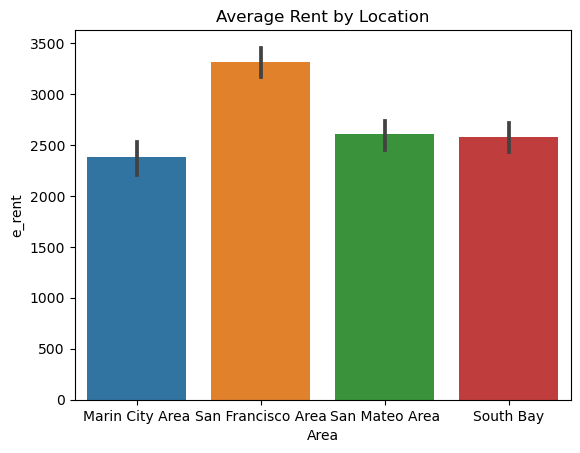

In [246]:
sns.barplot(data=grouped_df, x="Area", y="e_rent")
plt.title("Average Rent by Location")
plt.show()

In [256]:
grouped_df

,Area,y_dt,e_rent,New Business Count,Quarterly Total Population,Quarterly Total Housing
0,Marin City Area,2011-01-01,1780.333333,11,20060.666667,9040.000000
1,Marin City Area,2011-04-01,1661.333333,7,33452.000000,14744.000000
2,Marin City Area,2011-07-01,1734.600000,9,24593.000000,10798.200000
3,Marin City Area,2011-10-01,1504.666667,4,29065.666667,12581.000000
4,Marin City Area,2012-01-01,1524.500000,7,25780.250000,10954.000000
...,...,...,...,...,...,...
139,South Bay,2018-10-01,2893.142857,30,46714.142857,15637.142857
140,South Bay,2019-01-01,3067.800000,59,42206.200000,14572.000000
141,South Bay,2019-04-01,3144.000000,41,46364.250000,15786.500000
142,South Bay,2019-07-01,3200.666667,66,45552.666667,15671.555556


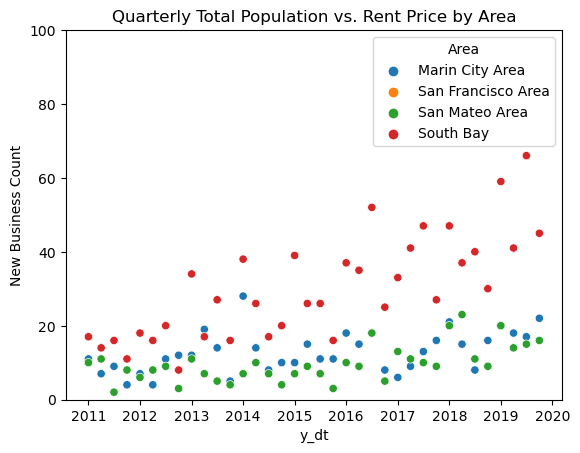

In [262]:
sns.scatterplot(data=grouped_df, x="y_dt", y="New Business Count", hue="Area")
plt.title("Quarterly Total Population vs. Rent Price by Area")
plt.ylim(0, 100)
plt.show()

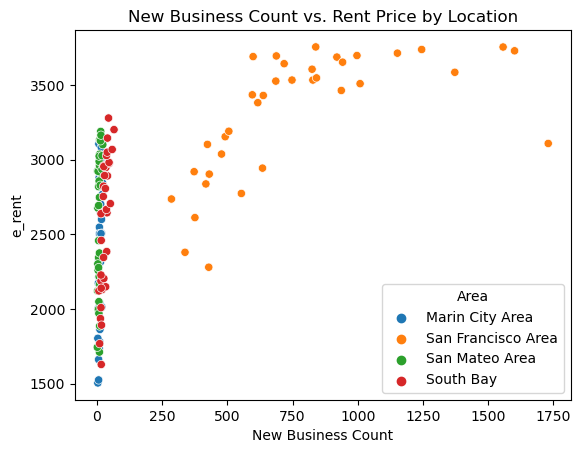

In [249]:
sns.scatterplot(data=grouped_df, x="New Business Count", y="e_rent", hue="Area")
plt.title("New Business Count vs. Rent Price by Location")
plt.show()